# ELE 435/535 Computational Lab 7

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Load MNIST Dataset 

We will be working with the subset of MNIST that was used for HW1 in this HW. The training data contains 10,000 samples of different digits. Let's call it matrix D (of dimension 784 * 10000). The first 1000 columns of D correspond to digit 0 ($D_0$), the next 1000 correspond to digit 1 ($D_1$), etc. 

In [2]:
train_data = np.load('./MNISTcwtrain1000.npy')
train_data = train_data.astype(dtype='float64')
test_data = np.load('./MNISTcwtest100.npy')
test_data = test_data.astype(dtype='float64')

train_data = train_data/255.0
test_data = test_data/255.0

### Q1) Collaborative Representation Based Classification Using Lasso

In HW4, we used least square regression for classifiying data. Given any new example (x), we would like to represent it as a linear combination of columns of D (hence, the name representation based classification). This can be acheived by finding a vector w (of dimension 1,000) that satisfies: $w = \arg\min \hspace{1mm} \|Dw - x \|_2$.

The first 100 elements of w ($w_0$) quantify how much of each column from digit 0 are needed to represent x. Similarly, the next 100 elements ($w_1$) correspond to weights on $D_1$, etc.

Next, prediction of pixel values of any test image (x) based only on examples of a particual digit $i$ can be found using $y_i' = D_i \times w_i$. Then, k-th digit that yields the lowest mean squared prediction error (i.e., $k = \arg\min \hspace{1mm} \|y -y'_i \|_2$) will determine the label of x. 

Following this procedure to predict the labels of each test example, the testing accuracy is 0.76.

#### * Use reduced training set ($Xr$) and test set ($test$) defined below. This will save the running time.

In [3]:
Xr=np.zeros((784,1000))
test=np.zeros((784,100))
for ind in range(10):
    Xr[:,100*ind:100*(ind+1)] = train_data[:,1000*ind:1000*ind+100]
    test[:,10*ind:10*(ind+1)] = test_data[:,100*ind:100*ind+10]

In [4]:
# least square
X = np.matrix(Xr)
[U,sigma,V] = np.linalg.svd( X, full_matrices=False)
index = np.where(sigma>1e-4)
trunc = index[0][-1]
INV_Mat = np.linalg.pinv(np.dot(X.T,X))
Projection_Mat = INV_Mat * (X.T) 
predicted_label = np.zeros((100,))
for i in range(0,100):
    test_ex = np.matrix(test[:,i]).T
    p = Projection_Mat * test_ex
    dist = np.zeros((10,))
    for j in range(0,10):
        sub_mat = X[:,j*100:(j+1)*100]
        sub_W = p[j*100:(j+1)*100]
        reconstructed = np.dot(sub_mat, sub_W)
        dist[j] = np.linalg.norm(reconstructed - test_ex)
    predicted_label[i] = np.argmin(dist)
true_label = np.zeros((100,))
for i in range(0,10):
    true_label[i*10:(i+1)*10] = i
test_err = np.count_nonzero(predicted_label - true_label)
test_acc = 1-(test_err/100.0)

print("Test Accuacy :::::: " + str(test_acc))

Test Accuacy :::::: 0.76


Now, instead of using least square, we use LASSO in this question to find a sparse $w$. The idea behind is that we only want to use a small number of training samples to represent the test sample. Then, the objective is to find a vector $w$ that satisfies: $w = \arg\min \hspace{2mm} \|Dw - x \|_2 ^2 + \lambda \|w \|_1$. 

1.Try $\lambda = 10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 1, 10, 100$ and plot testing accuracy vs. $\lambda$. Compare the testing accuracy with that from least square. 

You can use the Lasso solver in Scikit-learn (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html). Note that the objective function of Lasso solver in Scikit-learn might be different from what we defined here. Please adjust your arguments to the solver accordingly.

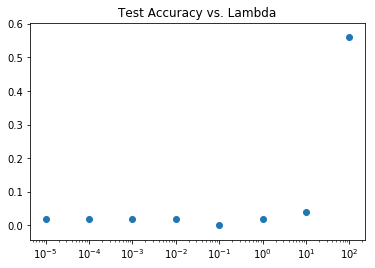

The testing accuracy is lower for LASSO which is to be expected since the classifier is not solely optimizing for error. Furthermore, the lambdas used below 10^0 all had numerical difficulties.


In [5]:
import warnings; warnings.simplefilter('ignore')
from sklearn import linear_model

# Number of "samples" in this case is actually features
num_samples = Xr.shape[0]

lambdas = [10**x for x in range(-5,3)]
accuracies_arr = []
non_zeros_arr = []
n_k_arr = []

for l in lambdas:
    alpha = l/(2.0*num_samples)
    clf = linear_model.Lasso(alpha=alpha)
    
    predicted_label = np.zeros((100,))
    non_zeros = 0
    n_k = 0
        
    for i in range(0,100):
        test_ex = np.matrix(test[:,i]).T
        dist = np.zeros((10,))
        
        clf.fit(Xr, test_ex)
        p = clf.coef_
        non_zeros += np.count_nonzero(p)
        k = i // 10
        
        if np.count_nonzero(p) > 0:
            n_k += np.count_nonzero(p[k*100:(k+1)*100])/np.count_nonzero(p)
        else:
            n_k += 1
        
        for j in range(0,10):
            sub_mat = X[:,j*100:(j+1)*100]
            sub_W = p[j*100:(j+1)*100]
            reconstructed = np.dot(sub_mat, sub_W)
            dist[j] = np.linalg.norm(reconstructed - test_ex)
            
        predicted_label[i] = np.argmin(dist)
        
    true_label = np.zeros((100,))
    
    for i in range(0,10):
        true_label[i*10:(i+1)*10] = i
        
    test_err = np.count_nonzero(predicted_label - true_label)
    test_acc = 1-(test_err/100.0)

    accuracies_arr.append(test_acc)
    non_zeros_arr.append(non_zeros/100)
    n_k_arr.append(n_k/100)
    
plt.figure()
plt.xscale('log')
plt.scatter(lambdas, accuracies_arr)
plt.title('Test Accuracy vs. Lambda')
plt.show()
print('The testing accuracy is lower for LASSO which is to be expected since the classifier is not solely optimizing for error. Furthermore, the lambdas used below 10^0 all had numerical difficulties.')

2.Plot the average number of nonzero entries in $w$ vs. $\lambda$.

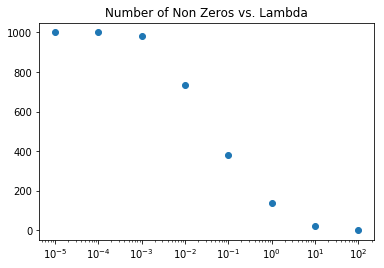

In [6]:
plt.figure()
plt.xscale('log')
plt.scatter(lambdas, non_zeros_arr)
plt.title('Number of Non Zeros vs. Lambda')
plt.show()

3.For each test sample, suppose $k$ is the right label, define $nk$ as nonzeros in $w_k$ / total # nonzeros in $w$. Plot the average of $nk$ over all testing samples vs. $\lambda$. What do you find?

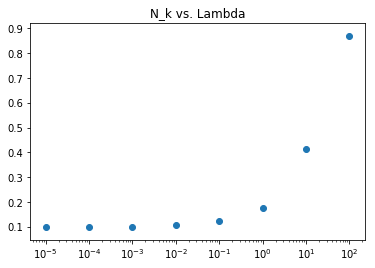

We find that N_k is 10% for bad classifiers (the zeros are distributed evenly) and then increases as the classifier becomes more sparse. That is, the sparse estimators focus the nonzeros on the correct class.


In [7]:
plt.figure()
plt.xscale('log')
plt.scatter(lambdas, n_k_arr)
plt.title('N_k vs. Lambda')
plt.show()
print('We find that N_k is 10% for bad classifiers (the zeros are distributed evenly) and then increases as the classifier becomes more sparse. That is, the sparse estimators focus the nonzeros on the correct class.')

### Q2) Collaborative Representation Based Classification Using Elastic Net

We now use the elastic net objective function to find $w$: $w = \arg\min \hspace{2mm} \|Dw - x \|_2 ^2 + \lambda (\alpha \|w \|_1+0.5(1-\alpha) \|w \|_2 ^2 )$. It linearly combines the $L1$ and $L2$ penalties. Choose an appropriate $\lambda$ from Q1, and vary $\alpha$ in the range $(0,1)$.

You can use Scikit-learn ElasticNet (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html). Refer to the documentation on the web.

4.Plot testing accuracy vs. $\alpha$. Compare the testing accuracy with that from least square and Lasso. 

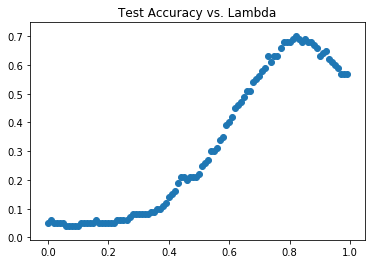

Using lambda=100, alpha~=0.82 yields the best performance slightly less than least squares before dipping back down to LASSO's result at alpha=1.0


In [8]:
from sklearn import linear_model

# Number of "samples" in this case is actually features
num_samples = Xr.shape[0]

alpha = 100/(2.0*num_samples)
l1_ratios = [x/100 for x in range(100)]
accuracies_arr = []
non_zeros_arr = []
n_k_arr = []

for l1_ratio in l1_ratios:
    clf = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    
    predicted_label = np.zeros((100,))
    non_zeros = 0
    n_k = 0
        
    for i in range(0,100):
        test_ex = np.matrix(test[:,i]).T
        dist = np.zeros((10,))
        
        clf.fit(Xr, test_ex)
        p = clf.coef_
        non_zeros += np.count_nonzero(p)
        k = i // 10
        
        if np.count_nonzero(p) > 0:
            n_k += np.count_nonzero(p[k*100:(k+1)*100])/np.count_nonzero(p)
        else:
            n_k += 1
        
        for j in range(0,10):
            sub_mat = X[:,j*100:(j+1)*100]
            sub_W = p[j*100:(j+1)*100]
            reconstructed = np.dot(sub_mat, sub_W)
            dist[j] = np.linalg.norm(reconstructed - test_ex)
            
        predicted_label[i] = np.argmin(dist)
        
    true_label = np.zeros((100,))
    
    for i in range(0,10):
        true_label[i*10:(i+1)*10] = i
        
    test_err = np.count_nonzero(predicted_label - true_label)
    test_acc = 1-(test_err/100.0)

    accuracies_arr.append(test_acc)
    non_zeros_arr.append(non_zeros/100)
    n_k_arr.append(n_k/100)
    
plt.figure()
plt.scatter(l1_ratios, accuracies_arr)
plt.title('Test Accuracy vs. Lambda')
plt.show()
print('Using lambda=100, alpha~=0.82 yields the best performance slightly less than least squares before dipping back down to LASSO\'s result at alpha=1.0')

5.Plot the average number of nonzero entries in $w$ vs. $\alpha$ and average $nk$ vs. $\alpha$. What do you find?

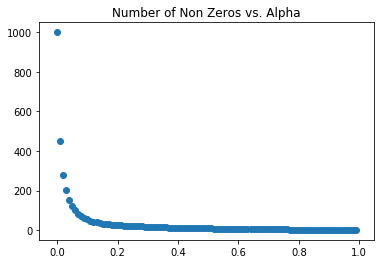

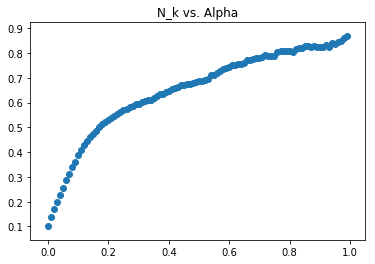

We find the number of non zeros goes to 0 as alpha increases which is to be expected. Also, N_k increases similarly to part 1).


In [9]:
plt.figure()
plt.scatter(l1_ratios, non_zeros_arr)
plt.title('Number of Non Zeros vs. Alpha')
plt.show()

plt.figure()
plt.scatter(l1_ratios, n_k_arr)
plt.title('N_k vs. Alpha')
plt.show()
print('We find the number of non zeros goes to 0 as alpha increases which is to be expected. Also, N_k increases similarly to part 1).')

### Q3) Orthogonal Matching Pursuit (OMP)

The general sparse least squares problem can be posed as below.
\begin{equation}
\min_{x\in\mathbb{R}^n} \|y-Ax\|_2^2
\end{equation}
\begin{equation}
\mbox{s.t.} \|x\|_0 \leq k 
\end{equation}

Orthogonal Matching Pursuit (OMP) is a greedy algorithm for sparse least squares problem above. Here, we are going to use OMP to find a sparse solution for a synthetic dataset. The dataset is defined below:

X (train) : 100 x 512
y (test) : 100 x 1
w (weight) : 512 x 1


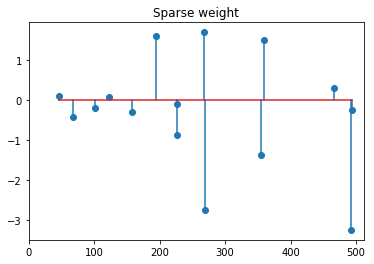

In [10]:
from sklearn import linear_model
from sklearn.datasets import make_sparse_coded_signal

y, X, w = make_sparse_coded_signal(n_samples=1,n_components=512,n_features=100,n_nonzero_coefs=15,random_state=0)
print('X (train) : ' + str(X.shape[0]) + ' x ' + str(X.shape[1]))
print('y (test) : ' + str(y.shape[0]) + ' x 1')
print('w (weight) : ' + str(w.shape[0]) + ' x 1')

idx, = w.nonzero()

plt.figure()
plt.stem(idx, w[idx])
plt.xlim([0,512])
plt.title('Sparse weight')
plt.show()

6.Use the orthogonal matching pursuit algorithm to find the $\hat{w}$ (coefficients) and compare it with the $w$ above (compute $\|w-\hat{w}\|_2^2$). (http://scikit-learn.org/stable/auto_examples/linear_model/plot_omp.html)

You can use scikit-learn OrthogonalMatchingPursuit (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.OrthogonalMatchingPursuit.html). Set $\mbox{n_nonzero_coefs}=20$, $\mbox{fit_intercept}=False$ and default for other parameters. 

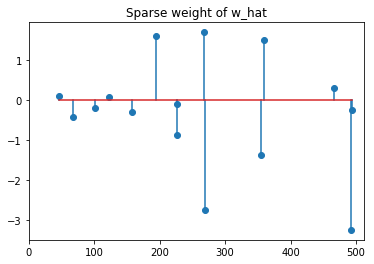

Euclidean distance between w and w_hat: 2.9537987557067033e-30


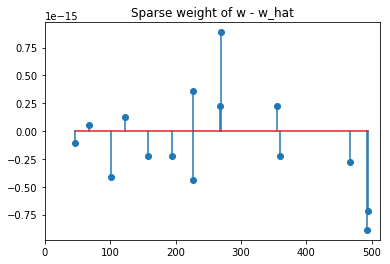

Notice the y sclae is 1e-15


In [11]:
from sklearn import linear_model

omp = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=20, fit_intercept=False).fit(X, y)
w_hat = omp.coef_
idx, = w_hat.nonzero()

plt.figure()
plt.stem(idx, w_hat[idx])
plt.xlim([0,512])
plt.title('Sparse weight of w_hat')
plt.show()

print('Euclidean distance between w and w_hat: ' + str(np.linalg.norm(w - w_hat)**2))

idx, = (w - w_hat).nonzero()

plt.figure()
plt.stem(idx, (w - w_hat)[idx])
plt.xlim([0,512])
plt.title('Sparse weight of w - w_hat')
plt.show()

print('Notice the y sclae is 1e-15')

7.Implement the OMP function yourself with following requirements. 
[Termination conditions]

1)Number of nonzero elements in $w$. 
\begin{equation}
\mbox{number of nonzero elements} = k
\end{equation}
2)Tolerance of the residual.
\begin{equation}
\frac{\|y-\hat{y}\|_2}{\|y\|_2} \leq \mbox{tolerance}
\end{equation}
3)Maximum number of iterations.

In [12]:
# Function outline
def omp(X,y,n_nonzero,tol,max_iter):
    t = 0
    S_t = []
    A_t = X[:,S_t]
    r_t = y
    
    while True:
        t += 1
        
        corrs = abs(np.dot(X.T, r_t))
        idx = corrs.argmax()
        S_t.append(idx)
        A_t = X[:,S_t]
        w_t = np.linalg.inv(A_t.T@A_t)@A_t.T@y
        r_t = y - A_t@w_t
        
        if ((np.count_nonzero(w_t) >= n_nonzero or np.linalg.norm(r_t)/np.linalg.norm(y) < tol or t >= max_iter)):
            break
            
    w = np.zeros(X.shape[1])
    
    for i in range(len(S_t)):
        w[S_t[i]] = w_t[i]
        
    return w

8.Repeat question 6 using your OMP function. (Set parameters as $\mbox{n_nonzero}=15$,$\mbox{tol}=10^{-30}$,$\mbox{max_iter}=300$)

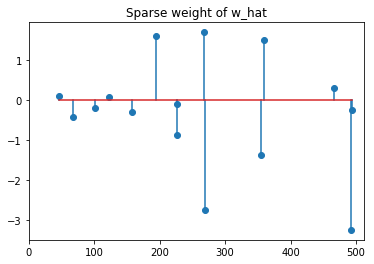

Euclidean distance between w and w_hat: 5.058454998933076e-30


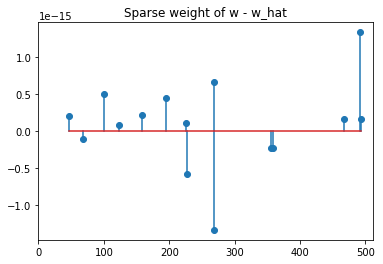

In [13]:
w_hat = omp(X,y,n_nonzero=15,tol=1e-30,max_iter=300)

idx, = w_hat.nonzero()

plt.figure()
plt.stem(idx, w_hat[idx])
plt.xlim([0,512])
plt.title('Sparse weight of w_hat')
plt.show()

print('Euclidean distance between w and w_hat: ' + str(np.linalg.norm(w - w_hat)**2))

idx, = (w - w_hat).nonzero()

plt.figure()
plt.stem(idx, (w - w_hat)[idx])
plt.xlim([0,512])
plt.title('Sparse weight of w - w_hat')
plt.show()

9.Try changing the tolerance value from $10^{-3}$ to $10^{-30}$ in log scale. 1)Plot the error ($\|w-\hat{w}\|_2^2$) vs. tolerance and 2)number of nonzero elements in $\hat{w}$ vs. tolerance. (Keep $\mbox{n_nonzero}=15$ and $\mbox{max_iter}=300$.)

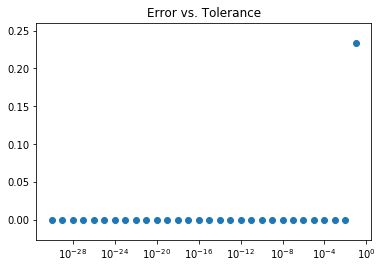

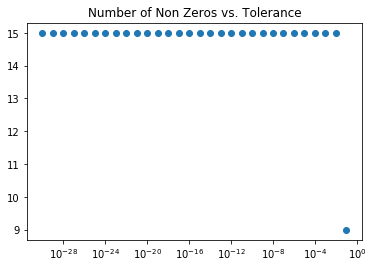

In [14]:
tols = [10**k for k in range(-30,0)]
errors_arr = []
non_zeros_arr = []

for tol in tols:
    
    w_hat = omp(X,y,n_nonzero=15,tol=tol,max_iter=300)
    errors_arr.append(np.linalg.norm(w - w_hat)**2)    
    non_zeros_arr.append(np.count_nonzero(w_hat))


plt.figure()
plt.xscale('log')
plt.scatter(tols, errors_arr)
plt.title('Error vs. Tolerance')
plt.show()

plt.figure()
plt.xscale('log')
plt.scatter(tols, non_zeros_arr)
plt.title('Number of Non Zeros vs. Tolerance')
plt.show()